In [1]:
# 自动加载python模块，不需要手动重启kernel
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/zsongah/tVAE_across_task_rat25_v2 
import torch
from configs.config import get_config
from data.dataset import Dataset
from runners.stVAE_runner import stVAE_runner
from runners.LFADS_runner import LFADS_runner
from runners.DFINE_runner import DFINE_runner
from scipy import stats
from evaluations.eval_utils import align_latent_mu
import matplotlib.pyplot as plt
import numpy as np
from decoders.KRL import KRL

/home/zsongah/.conda/envs/transformer/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/zsongah/tVAE_across_task_rat25_v2


In [3]:
# settings
model_names = ['stVAE','LFADS','DFINE'] # model folder
experiment_names = ['stVAE','LFADS','DFINE'] # experiment name
rat = '025'
latent_dim = 6
task_1mc = '1MC'
task_2mc = '2MC'
day_1mc = '2020-07-16'
day_2mc = '2020-10-05'
test_fold = 0  
# load model from 1MC
load_file_prefix = f'{rat}_{task_1mc}_{day_1mc}_{test_fold}fold_' \
                f'{latent_dim}latent_' 
model_files = [f'results/{model_name}/{load_file_prefix}{experiment_name}.pth' for 
               model_name, experiment_name in zip(model_names, experiment_names)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# get model results
tasks = [task_1mc, task_2mc]
days = [day_1mc, day_2mc]
model_results = {name: {} for name in model_names}
for model_file, model_name in zip(model_files, model_names):
    config_file = model_name
    checkpoint = torch.load(model_file,map_location=device)
    for day, task in zip(days, tasks):
        config = get_config(config_file, [
                'DATA.RAT', rat,
                'DATA.TASK', task,
                'DATA.DAY', day, # can not use number_number 
                'DATA.TEST_FOLD', test_fold,
                'MODEL.LATENT_DIM', latent_dim,
            ])
        dataset = Dataset(config, rat, day, task, test_fold, device)
        if model_name == 'stVAE':
            runner = stVAE_runner(config, dataset, model_name) 
        elif model_name == 'LFADS':
            runner = LFADS_runner(config, dataset, model_name)
        elif model_name == 'DFINE':
            runner = DFINE_runner(config, dataset, model_name)
        runner.model.load_state_dict(checkpoint['model_state_dict'])
        runner.model.eval()
        result_test = runner.evaluate()
        result_train = runner.eval_train()
        model_results[model_name][task] = {
            'result_test': result_test,
            'result_train': result_train
        }

/tmp/ipykernel_88429/2302018865.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file,map_location=device)


| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 
| load neural data | train length: 13438, trial: 141 | test length: 3814 , trial: 35 | 32 total neurons | 16 M1 neurons | 


/tmp/ipykernel_88429/2302018865.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file,map_location=device)


| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 
| load neural data | train length: 13438, trial: 141 | test length: 3814 , trial: 35 | 32 total neurons | 16 M1 neurons | 
| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 
| load neural data | train length: 13438, trial: 141 | test length: 3814 , trial: 35 | 32 total neurons | 16 M1 neurons | 


In [4]:
scaled_latent_state ={model:{} for model in model_names}
for model_name in model_names:
     for task in tasks:
        latent_mu = stats.zscore(model_results[model_name][task]['result_train']['latent_mu'],axis=0)
        actions = model_results[model_name][task]['result_train']['actions']
        scaled_latent_state[model_name][task], len_start, len_press, len_release, len_after_release, trial_types = align_latent_mu(actions, latent_mu)
        
cue_start = len_start-1
press_lever = len_start + len_press - 1
release_lever = len_start + len_press + len_release - 1
trial_num, trial_length, feature_num = scaled_latent_state['stVAE']['2MC'].shape
start_point = cue_start
end_point = press_lever


In [5]:
learning_curve_2MC = {model:{} for model in model_names}
for model in model_names:
    KRL_decoder = KRL(
        model_name=model,
        latent_one_lever=scaled_latent_state[model]['1MC'],
        latent_two_lever=scaled_latent_state[model]['2MC'],
        trial_types_2MC=trial_types,
        cue_start=cue_start,
        press_lever=press_lever,
        release_lever=release_lever
    )
    acc_1MC = KRL_decoder.train_on_MC1()
    acc_2MC = KRL_decoder.train_on_MC2()
    learning_curve_2MC[model] = acc_2MC

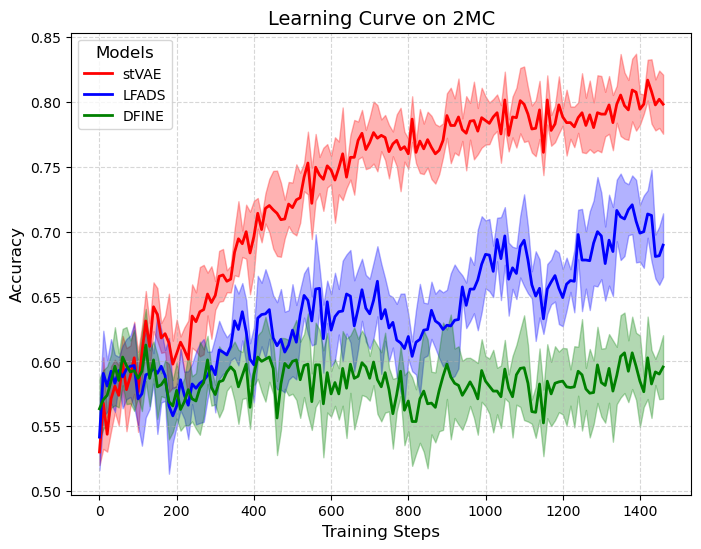

In [6]:
val_interval = KRL_decoder.val_interval
colors = {
    'stVAE': 'red',
    'LFADS': 'blue',
    'DFINE': 'green'
}
fig, ax = plt.subplots(figsize=(8, 6))
for model in model_names:
    mean_acc = np.mean(learning_curve_2MC[model], axis=0)
    std_acc = np.std(learning_curve_2MC[model], axis=0)
    x = np.arange(0,len(mean_acc)) * val_interval
    plt.plot(x,mean_acc,label=model,color=colors[model],linewidth=2)
    plt.fill_between(x,mean_acc-std_acc,mean_acc+std_acc,alpha=0.3,color=colors[model])
plt.title('Learning Curve on 2MC', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10, title='Models', title_fontsize=12)
plt.grid(True,linestyle='--',alpha=0.5)
plt.show()